In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tensorflow as tf
import scipy

from sklearn.metrics import roc_curve, auc, precision_recall_curve

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import helper 

from Bio import AlignIO
import time as time
import pandas as pd

In [2]:
'''SAVE PATHS AND PARAMETERS'''
params_results = '../../../results'
exp_folder = 'toypk'

modelarch = 'rnn'
trial = 't2'
modelsavename = '%s_%s'%(modelarch, trial)

# Load Data, get base paired indices and remove gaps

In [3]:
starttime = time.time()

#Open data from h5py

data_path = '../../../data_toypk/toypk_50_d2.hdf5'
with h5py.File(data_path, 'r') as dataset:
    X_data = np.array(dataset['X_data'])
    Y_data = np.array(dataset['Y_data'])

numdata, seqlen, dims = X_data.shape
X_data = np.expand_dims(X_data, axis=2)
    
# get validation and test set from training set
test_frac = 0.3
valid_frac = 0.1
N = numdata
split_1 = int(N*(1-valid_frac-test_frac))
split_2 = int(N*(1-test_frac))
shuffle = np.random.permutation(N)

X_train = X_data[shuffle[:split_1], :, 0, :]
X_valid = X_data[shuffle[split_1:split_2], :, 0, :]
X_test = X_data[shuffle[split_2:], :, 0, :]

Y_train = Y_data[shuffle[:split_1]]
Y_valid = Y_data[shuffle[split_1:split_2]]
Y_test = Y_data[shuffle[split_2:]]
    
print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))

Data extraction and dict construction completed in: 0.33s


# Build the 2 layer LSTM

In [4]:
tf.reset_default_graph()

num_hidden = 64
num_layers = 2
num_classes = Y_train.shape[1]

# tf Graph input
X = tf.placeholder(tf.float32, [None, None, X_train[0].shape[1]], name='inputs')
Y = tf.placeholder(tf.float32, [None, num_classes], name='ouputs')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

lstm1_fw_cell = tf.nn.rnn_cell.LSTMCell(num_hidden)#, forget_bias=1.0)
lstm1_fw_cell = tf.contrib.rnn.DropoutWrapper(lstm1_fw_cell, 
                                         output_keep_prob=keep_prob, 
                                         state_keep_prob=1.0,
                                         variational_recurrent=False,
                                         dtype=tf.float32)

lstm1_bw_cell = tf.nn.rnn_cell.LSTMCell(num_hidden)#, forget_bias=1.0)
lstm1_bw_cell = tf.contrib.rnn.DropoutWrapper(lstm1_bw_cell, 
                                         output_keep_prob=keep_prob, 
                                         state_keep_prob=1.0,
                                         variational_recurrent=False,
                                         dtype=tf.float32)

outputs1, states1 = tf.nn.bidirectional_dynamic_rnn(lstm1_fw_cell, lstm1_bw_cell, X, 
                                                   sequence_length=helper.length(X), dtype=tf.float32,
                                                   scope='BLSTM_1')

outputs_forward, outputs_backward = outputs1

# states_forward is a tuple of (c is the hidden state and h is the output)
concat_outputs = tf.concat([outputs_forward, outputs_backward], axis=2, name='intermediate')

lstm2_fw_cell = tf.nn.rnn_cell.LSTMCell(num_hidden)#, forget_bias=1.0)
lstm2_fw_cell = tf.contrib.rnn.DropoutWrapper(lstm2_fw_cell, 
                                         output_keep_prob=keep_prob, 
                                         state_keep_prob=1.0,
                                         variational_recurrent=False,
                                         dtype=tf.float32)

lstm2_bw_cell = tf.nn.rnn_cell.LSTMCell(num_hidden)#, forget_bias=1.0)
lstm2_bw_cell = tf.contrib.rnn.DropoutWrapper(lstm2_bw_cell, 
                                         output_keep_prob=keep_prob, 
                                         state_keep_prob=1.0,
                                         variational_recurrent=False,
                                         dtype=tf.float32)

outputs2, states2 = tf.nn.bidirectional_dynamic_rnn(lstm2_fw_cell, lstm2_bw_cell, concat_outputs,
                                                    scope='BLSTM_2', dtype=tf.float32)

states_forward, states_backward = states2

# states_forward is a tuple of (c is the hidden state and h is the output)
concat_states = tf.concat([states_forward[1], states_backward[1]], axis=1, name='output')

# Linear activation, using rnn inner loop last output
W_out = tf.Variable(tf.random_normal([num_hidden*2, num_classes]))
b_out = tf.Variable(tf.random_normal([num_classes]))

#last = tf.gather(outputs, int(outputs.get_shape()[1])-1)  
#last = int(outputs.get_shape()[1]) - 1
logits = tf.matmul(concat_states, W_out) + b_out
predictions = tf.nn.sigmoid(logits)

In [5]:
# The Optimizer

learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# Define loss and optimizer
predictions = tf.clip_by_value(predictions, clip_value_max=1-1e-7, clip_value_min=1e-7)
#cost = tf.reduce_sum(Y*tf.log(predictions), axis=1)
cost = tf.reduce_sum(Y*tf.log(predictions)+(1-Y)*tf.log(1-predictions), axis=1)

total_loss = tf.reduce_mean(-cost)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
grads = optimizer.compute_gradients(total_loss)

# Apply gradients.
apply_gradient_op = optimizer.apply_gradients(grads)

# Track the moving averages of all trainable variables.
variable_averages = tf.train.ExponentialMovingAverage(0.9)
variables_averages_op = variable_averages.apply(tf.trainable_variables())

with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
    train_op = tf.no_op(name='train')

# Evaluate model (with test logits, for dropout to be disabled)
#correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(Y, 1))
correct_pred = tf.equal(tf.round(predictions), Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Train model

In [6]:
# start session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
batch_size = 128
train_batches = helper.bucket_generator(X_train, Y_train, batch_size)
valid_batches = helper.bucket_generator(X_valid, Y_valid, batch_size)
num_epochs = 50
bar_length = 25
patience = 10


# path to save results
save_path = os.path.join(params_results, exp_folder)
if not os.path.isdir(save_path):
    os.mkdir(save_path)
    print("making directory: " + save_path)
params_filename = '%s_%s_best'%(modelarch, trial)
params_path = os.path.join(save_path, params_filename)
    
wait=0
min_loss = 1e10
for epoch in range(num_epochs):
    print('epoch: '+ str(epoch+1))
    
    num_batches = len(train_batches)
    shuffled_batches = []
    for i in np.random.permutation(num_batches):
        shuffled_batches.append(train_batches[i])
        
    loss = 0
    acc = 0
    start_time = time.time()
    for i, batch in enumerate(shuffled_batches):
        batch_loss, batch_acc, _ = sess.run([total_loss, accuracy, train_op], feed_dict={X: batch[0], 
                                                                                      Y: batch[1], 
                                                                                      keep_prob: 0.5,
                                                                                      learning_rate: 0.0003})            
        loss += batch_loss
        acc += batch_acc

        remaining_time = (time.time()-start_time)*(num_batches-(i+1))/(i+1)
        percent = float(i)/num_batches
        progress = '='*int(round(percent*bar_length))
        spaces = ' '*int(bar_length-round(percent*bar_length))
        sys.stdout.write("\r[%s] %.1f%% -- remaining time=%.2fs -- loss=%.5f -- acc=%.5f" \
        %(progress+spaces, percent*100, remaining_time, loss/(i+1), acc/(i+1)))
        
    sys.stdout.write("\r[%s] %.1f%% -- elapsed time=%.2fs -- loss=%.5f -- acc=%.5f\n" \
    %(progress+spaces, percent*100, time.time()-start_time, loss/(i+1), acc/(i+1)))
    sys.stdout.write("\n")
    
    
    num_batches = len(valid_batches)
    loss = 0
    acc = 0
    valid_predictions = []
    valid_truth = []
    start_time = time.time()
    for i, batch in enumerate(valid_batches):
        batch_loss, batch_predict = sess.run([total_loss, predictions], feed_dict={X: batch[0], 
                                                                                Y: batch[1], 
                                                                                keep_prob: 1.0})            
        loss += batch_loss
        valid_predictions.append(batch_predict)
        valid_truth.append(batch[1])
    valid_loss = loss/num_batches
    valid_predictions = np.vstack(valid_predictions)
    valid_truth = np.vstack(valid_truth)
    
    correct = np.mean(np.equal(valid_truth, np.round(valid_predictions)))
    auc_roc, roc_curves = helper.roc(valid_truth, valid_predictions)
    auc_pr, pr_curves = helper.pr(valid_truth, valid_predictions)
    print("  valid loss  = "+str(loss/num_batches))
    print("  valid acc   = "+str(np.nanmean(correct)))
    print("  valid AUROC = "+str(np.nanmean(auc_roc)))
    print("  valid AUPRC = "+str(np.nanmean(auc_pr)))
    
    # check if current validation loss is lower, if so, save parameters, if not check patience
    if valid_loss < min_loss:
        print("  Lower validation loss found. Saving parameters to: "+params_path)
        
        # save model parameters
        saver = tf.train.Saver()
        saver.save(sess, save_path=params_path)
        
        # set minimum loss to the current validation loss
        min_loss = valid_loss
        
        # reset wait time
        wait = 0
    else:
        
        # add to wait time
        wait += 1
        
        # check to see if patience has run out
        if wait == patience:
            print("Patience ran out... early stopping!")
            break

epoch: 1
[=========================] 99.8% -- elapsed time=41.48s -- loss=0.69651 -- acc=0.4976004

  valid loss  = 0.693517990504639
  valid acc   = 0.5003
  valid AUROC = 0.5029998410799428
  valid AUPRC = 0.5020850656547884
  Lower validation loss found. Saving parameters to: ../../../results/toypk/rnn_t2_best
epoch: 2
[=========================] 99.8% -- elapsed time=41.22s -- loss=0.69466 -- acc=0.4986664

  valid loss  = 0.6936789856681341
  valid acc   = 0.5042
  valid AUROC = 0.5047722817180215
  valid AUPRC = 0.5076224558410982
epoch: 3
[=========================] 99.8% -- elapsed time=42.08s -- loss=0.67395 -- acc=0.5580887

  valid loss  = 0.630605018591579
  valid acc   = 0.6364
  valid AUROC = 0.6875870875313516
  valid AUPRC = 0.663589788210944
  Lower validation loss found. Saving parameters to: ../../../results/toypk/rnn_t2_best
epoch: 4
[=========================] 99.8% -- elapsed time=41.24s -- loss=0.61574 -- acc=0.6500550

  valid loss  = 0.5539989324310158
  valid 

In [10]:
# close tensorflow session (Note, the graph is still open)
sess.close()

# Test Model

In [13]:

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# path to save results
save_path = os.path.join(params_results, exp_folder)
params_filename = '%s_%s_best'%(modelarch, trial)
params_path = os.path.join(save_path, params_filename)

# restore trained parameters
saver = tf.train.Saver()
saver.restore(sess, save_path=params_path)

INFO:tensorflow:Restoring parameters from ../../../results/toypk/rnn_t2_best


In [14]:
batch_size = 128
batches, sort_index = helper.bucket_generator(X_test, Y_test, batch_size, index=True)
num_batches = len(batches)

loss = 0
acc = 0
valid_predictions = []
valid_truth = []
start_time = time.time()
num_batches = len(batches)
bar_length = 25

for i, batch in enumerate(batches):

    batch_loss, batch_predict = sess.run([total_loss, predictions], feed_dict={X: batch[0], 
                                                                            Y: batch[1], 
                                                                            keep_prob: 1.0})            
    loss += batch_loss
    valid_predictions.append(batch_predict)
    valid_truth.append(batch[1])
    
    remaining_time = (time.time()-start_time)*(num_batches-(i+1))/(i+1)
    percent = float(i)/num_batches
    progress = '='*int(round(percent*bar_length))
    spaces = ' '*int(bar_length-round(percent*bar_length))
    sys.stdout.write("\r[%s] %.1f%% -- remaining time=%.2fs -- loss=%.5f -- acc=%.5f" \
    %(progress+spaces, percent*100, remaining_time, loss/(i+1), acc/(i+1)))

sys.stdout.write("\r[%s] %.1f%% -- elapsed time=%.2fs -- loss=%.5f -- acc=%.5f\n" \
%(progress+spaces, percent*100, time.time()-start_time, loss/(i+1), acc/(i+1)))
sys.stdout.write("\n")

valid_predictions = np.vstack(valid_predictions)
valid_truth = np.vstack(valid_truth)

correct = np.mean(np.equal(valid_truth, np.round(valid_predictions)))
auc_roc, roc_curves = helper.roc(valid_truth, valid_predictions)
auc_pr, pr_curves = helper.pr(valid_truth, valid_predictions)
mean = [np.nanmean(correct), np.nanmean(auc_roc), np.nanmean(auc_pr)]
std = [np.nanstd(correct), np.nanstd(auc_roc), np.nanstd(auc_pr)]

print("  test loss  = "+str(loss/num_batches))
print("  test acc   = "+str(np.nanmean(correct)))
print("  test AUROC = "+str(np.nanmean(auc_roc)))
print("  test AUPRC = "+str(np.nanmean(auc_pr)))

[=========================] 99.6% -- elapsed time=6.96s -- loss=0.01531 -- acc=0.0000000

  test loss  = 0.015305275623835227
  test acc   = 0.9955333333333334
  test AUROC = 0.9996841630954699
  test AUPRC = 0.9996464636023026


In [15]:
WT_predictions = valid_predictions[np.argsort(sort_index)]
plot_index = np.argsort(WT_predictions[:,0])[::-1]

# Second Order Mutagenesis

In [16]:
def second_order_mutagenesis(sess, predictions, X_val, ugidx):
    seqlen, dims = X_val.shape
    idxlen = len(ugidx)

    # get wild-type score
    wt_score = sess.run(predictions, feed_dict={X: np.expand_dims(X_val, axis=0), keep_prob: 1.0})[0]     

    # generate mutagenesis sequences
    num_mut = idxlen**2*dims**2
    X_mut = np.einsum('nl,lka->nka', np.ones((num_mut, 1)), np.expand_dims(X_val, axis=0))

    k=0
    for position1 in ugidx:
        for position2 in ugidx:
            for nuc1 in range(dims):
                for nuc2 in range(dims):
                    X_mut[k, position1, :] = 0
                    X_mut[k, position1, nuc1] = 1        
                    X_mut[k, position2, :] = 0
                    X_mut[k, position2, nuc2] = 1        
                    k += 1

    # get second order mutagenesis score
    X_mut = [x for x in X_mut]
    mut_scores = []
    batches = helper.batch_generator(X_mut, batch_size=512, MAX=None, shuffle_data=False)
    for i, batch in enumerate(batches):
        batch_predict = sess.run(predictions, feed_dict={X: batch, keep_prob: 1.0})            
        mut_scores.append(batch_predict)
    mut_scores = np.vstack(mut_scores)
    
    # calculate log-odds score
    log_odds = np.log(mut_scores + 1e-7) - np.log(wt_score + 1e-7)


    # reshape second order scores
    second_mutagenesis_logodds = np.zeros((idxlen, idxlen, dims, dims))
    second_mutagenesis_just = np.zeros((idxlen, idxlen, dims, dims))
    k = 0
    for i in range(idxlen):
        for j in range(idxlen):
            for m in range(dims):
                for n in range(dims):
                    second_mutagenesis_logodds[i,j,m,n] = log_odds[k,0]
                    second_mutagenesis_just[i,j,m,n] = mut_scores[k,0]
                    k += 1
    return second_mutagenesis_logodds, second_mutagenesis_just

In [17]:
som_logits = []
for layer in [logits]:
    start_time = time.time()
    np.random.seed(274)

    bar_length = 50
    N = 2000
    mutagenesis_logodds = []
    mutagenesis_just = []
    for i, index in enumerate(plot_index[:N]):
        logresult, justresult = second_order_mutagenesis(sess, layer, X_test[index], range(seqlen))
        mutagenesis_logodds.append(logresult)
        mutagenesis_just.append(justresult)


        remaining_time = (time.time()-start_time)*(N-(i+1))/(i+1)
        percent = float(i)/N
        progress = '='*int(round(percent*bar_length))
        spaces = ' '*int(bar_length-round(percent*bar_length))
        sys.stdout.write("\r[%s] %.1f%% -- remaining time=%.2fs" \
        %(progress+spaces, percent*100, remaining_time))

    sys.stdout.write("\r[%s] %.1f%% -- elapsed time=%.2fs" \
    %(progress+spaces, percent*100, time.time()-start_time))
    sys.stdout.write("\n")
    
    som_logits.append([mutagenesis_logodds, mutagenesis_just])



/home/peter/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in log


[==================================================] 100.0% -- elapsed time=7711.20ss


In [32]:
results = [np.nanmean(som_logits[0][i], axis=0) for i in [0,1]]

TypeError: 'int' object has no attribute '__getitem__'

In [34]:
arrayspath = 'Arrays/%s_%s%s_so.npy'%(exp_folder, modelarch, trial)

np.save(arrayspath, results)

In [37]:
arrayspath = 'Arrays/%s_%s%s_so.npy'%(exp_folder, modelarch, trial)

som_logits = np.load(arrayspath)

In [39]:
def normalize_mut_hol(hol_mut, normfactor=None):
    norm_hol_mut = np.copy(hol_mut)
    for one in range(hol_mut.shape[0]):
        for two in range(hol_mut.shape[0]):
            norm_hol_mut[one, two] = mf.normalize_hol(hol_mut[one, two], factor=normfactor)
    return norm_hol_mut

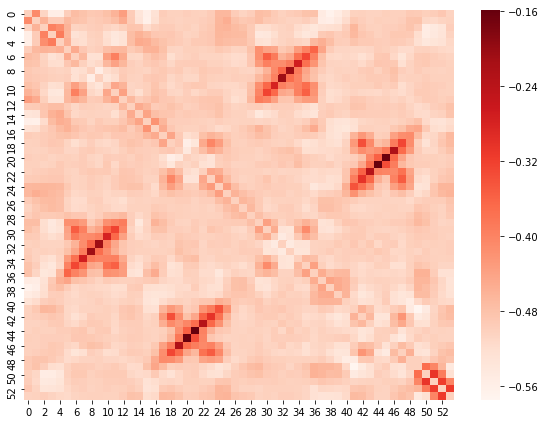

In [70]:
for m in [som_logits]:
    for t in [0]:
        mutagenesis = m[t]

        norm_mean_mut2 = normalize_mut_hol(mutagenesis, normfactor=1)

        #Let's try something weird
        bpfilter = np.ones((4,4))*-1
        for i,j in zip(range(4), range(4)):
            bpfilter[i, -(j+1)] = 1.

        #C = np.sum((mean_mut2*bpfilter).reshape(numug,numug,dims*dims), axis=2)
        #norm_mean_mut2= mean_mut2 + np.min(mean_mut2)#np.exp(norm_mean_mut2)  #
        C = np.sum((norm_mean_mut2*bpfilter).reshape(seqlen,seqlen,dims*dims), axis=2)
        #C = C - np.mean(C)
        #C = C/np.max(C)

        color = 'Reds'

        plt.figure(figsize=(8,6))
        sb.heatmap(C, vmin=None, cmap=color , linewidth=0.00)



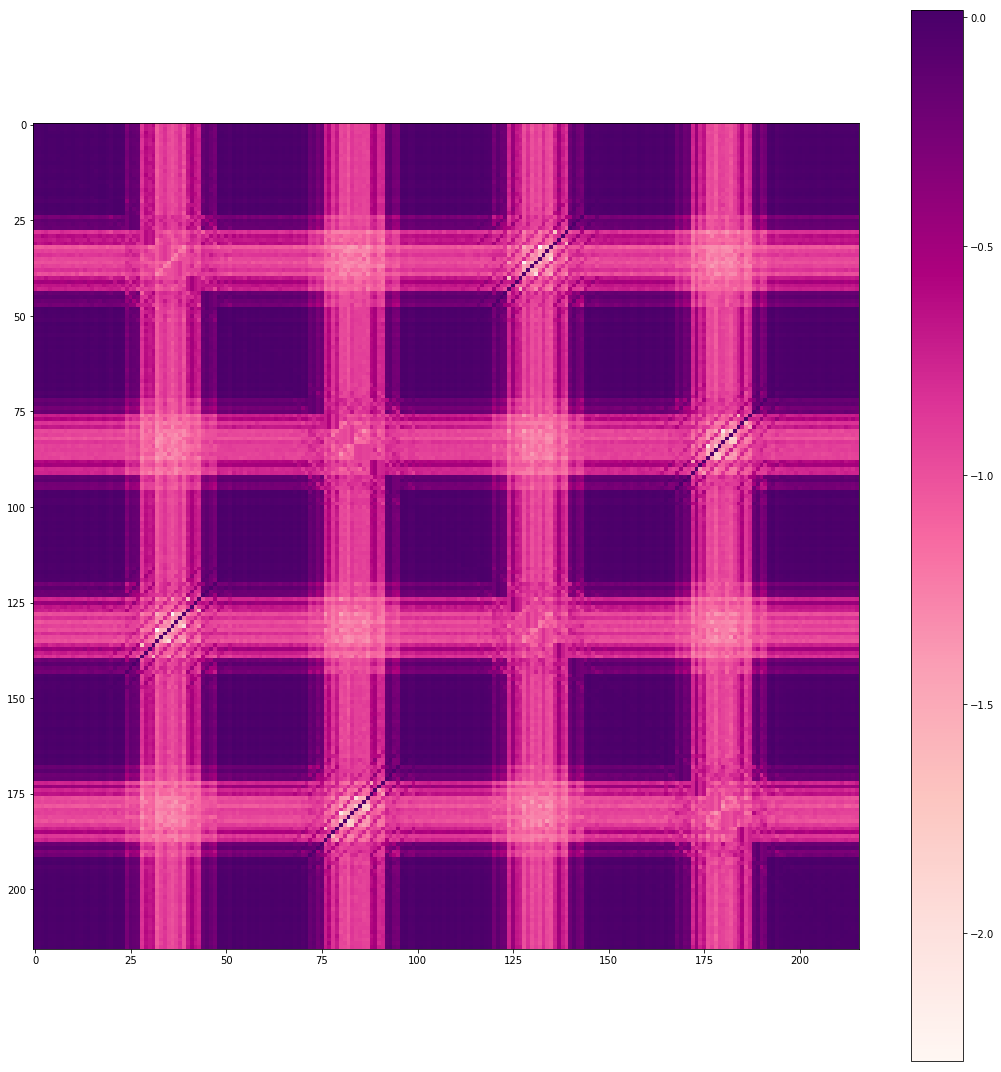

In [83]:
blocklen = np.sqrt(np.product(mutagenesis.shape)).astype(int)
S = np.zeros((blocklen, blocklen))
i,j,k,l = mutagenesis.shape

for ii in range(i):
    for jj in range(j):
        for kk in range(k):
            for ll in range(l):
                S[(4*ii)+kk, (4*jj)+ll] = mutagenesis[ii,jj,kk,ll]

plt.figure(figsize=(15,15))
plt.imshow(S,  cmap='RdPu')
plt.colorbar()